In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization , Dropout
from keras.layers.core import Lambda
from keras.models import Model , load_model , model_from_json
import keras.backend as K

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


#### Pruebas matemáticas para probar los cálculos

In [25]:
true = K.random_uniform(shape = (5,1), minval=0.0, maxval=50.0, dtype=None, seed=None)
true_error = K.random_uniform(shape = (5,1), minval=0.0, maxval=1.0, dtype=None, seed=None)
pred = K.random_uniform(shape = (5,1), minval=0.0, maxval=50.0, dtype=None, seed=None)

In [26]:
print("true: ", true ,"\n","-------------------","\n", "pred: ", pred)

true:  tf.Tensor(
[[ 9.449398 ]
 [24.156666 ]
 [13.77474  ]
 [ 0.8261502]
 [40.93929  ]], shape=(5, 1), dtype=float32) 
 ------------------- 
 pred:  tf.Tensor(
[[39.02463   ]
 [20.839184  ]
 [27.977121  ]
 [38.462723  ]
 [ 0.75920224]], shape=(5, 1), dtype=float32)


In [27]:
print("delta: " , true - pred ,"\n","-------------------","\n", "delta_square: " , K.square(true - pred))

delta:  tf.Tensor(
[[-29.575233]
 [  3.317482]
 [-14.202381]
 [-37.636574]
 [ 40.180088]], shape=(5, 1), dtype=float32) 
 ------------------- 
 delta_square:  tf.Tensor(
[[ 874.69446 ]
 [  11.005687]
 [ 201.70763 ]
 [1416.5117  ]
 [1614.4395  ]], shape=(5, 1), dtype=float32)


In [28]:
print("true_error: " ,true_error,"\n","-------------------","\n", 
      "square_error: " ,K.square(true_error),"\n","-------------------","\n", 
      "ln(true_error): " ,K.log(true_error))

true_error:  tf.Tensor(
[[0.15048528]
 [0.43249726]
 [0.77380157]
 [0.46415055]
 [0.5773468 ]], shape=(5, 1), dtype=float32) 
 ------------------- 
 square_error:  tf.Tensor(
[[0.02264582]
 [0.18705389]
 [0.5987689 ]
 [0.21543573]
 [0.33332932]], shape=(5, 1), dtype=float32) 
 ------------------- 
 ln(true_error):  tf.Tensor(
[[-1.89389  ]
 [-0.8381793]
 [-0.2564398]
 [-0.7675463]
 [-0.5493122]], shape=(5, 1), dtype=float32)


In [29]:
print("delta_square: " , K.square(true - pred),"\n","-------------------","\n", 
      "square_error: " ,K.square(true_error),"\n","-------------------","\n", 
      "delta_square / square_error: " ,tf.divide(K.square(true - pred),K.square(true_error)))

delta_square:  tf.Tensor(
[[ 874.69446 ]
 [  11.005687]
 [ 201.70763 ]
 [1416.5117  ]
 [1614.4395  ]], shape=(5, 1), dtype=float32) 
 ------------------- 
 square_error:  tf.Tensor(
[[0.02264582]
 [0.18705389]
 [0.5987689 ]
 [0.21543573]
 [0.33332932]], shape=(5, 1), dtype=float32) 
 ------------------- 
 delta_square / square_error:  tf.Tensor(
[[38624.99    ]
 [   58.836983]
 [  336.87057 ]
 [ 6575.101   ]
 [ 4843.3765  ]], shape=(5, 1), dtype=float32)


In [30]:
print("mean: " , K.mean(tf.divide(K.square(true - pred),K.square(true_error))))

mean:  tf.Tensor(10087.834, shape=(), dtype=float32)


### Contrucción del Loss y del modelo

In [21]:
def custom_loss(y_error): 
    def loss(y_true, y_pred):
        #print("true: ",y_true, "pred: ", y_pred, "error: ", y_error)
        delta_square = K.square(y_true - y_pred)
        #print("delta_square: ",delta_square)
        return  K.mean((1/2 * tf.divide(delta_square , K.square(y_error))) +
                (1/2 * K.log(K.square(y_error))))       
    return loss

#INTENTAR DEFINIR EL MSE CON ESTA FUNCIÓN (ver si funciona hasta plot MAD)
# El rendimiento de la red y la búsqueda de los pesos dependerá de la media???

In [22]:
def ApogeeDR14GaiaDR2(dim_t , dim_n, dropout_iterations = 100): 
    """
    INPUT: 
    dim_t - number of time steps of spectrum 
    dim_n - number of features of spectrum
    """
    
    #SPECTRUM TO LUINOSITY
    dim_1 = 1 # number of corrected magnitude for one example 
    units = 1 #number of final output for one example
    
    inputs_spectra = Input(shape=(dim_t, dim_n), name="pseudo-lum-input") 
    inputs_mag = Input(shape=(dim_1,), name="K_mag")
    inputs_error_paralaje = Input(shape=(dim_1,), name="error_paralaje")
    print("inputs_mag: ",inputs_mag)
    print("inputs_error_paralaje: ",inputs_error_paralaje)
    
    
    #x_parallax_list = []
    
    #for i in range(droput_iterations):
    x_parallax = Conv1D(filters=2, kernel_size=3, activation='relu')(inputs_spectra)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)

    x_parallax = Conv1D(filters=4, kernel_size=3, activation='relu')(x_parallax)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)

    x_parallax = Flatten()(x_parallax)
    x_parallax = Dense(128, activation='relu')(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
        
    x_parallax = Dense(64, activation='relu')(x_parallax) 
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
    x_parallax = Dense(32, activation='relu')(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
    x_parallax = Dense(units, activation='softplus', name="pseudo-lum")(x_parallax) 

    #OFFSET CORRECTION : (optimization)
    inputs_offset = Input(shape=(3,), name="offset-input")
    x_offset = Dense(64, activation='relu')(inputs_offset)
    x_offset = Dense(32, activation='relu')(x_offset) 
    x_offset = Dense(units, activation='tanh', name="offset")(x_offset) 
    
    #Functions
    outputs_parallax = Lambda(lambda function: tf.math.multiply(function[0], tf.math.pow(10., 
                              tf.math.multiply(-0.2, function[1]))),
                              name='parallax')([x_parallax, inputs_mag])
    
    outputs_parallax_with_offset = Lambda(lambda function: tf.math.add(function[0], function[1]),
                                          name="sum-parallax-offset")([outputs_parallax, x_offset]) 
    
    #Model setup
    model =  Model(inputs = [inputs_spectra,inputs_mag, inputs_offset,inputs_error_paralaje],outputs = [outputs_parallax_with_offset])

    model.compile(loss=custom_loss(y_error=inputs_error_paralaje), optimizer='adam', metrics=['mse']) 
    
    return model 

#### Data load 

In [4]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])

In [5]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [6]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra, axis = 2)
Y = np.expand_dims(parallax, axis = 1)
K_mag = np.expand_dims(Kmag, axis = 1)
Y_error = np.expand_dims(parallax_error, axis = 1)

# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag)
Gmag_mean = np.mean(Gmag)
Gmag_norm = (Gmag - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
bp_rp_norm = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
teff_norm = (teff - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)

X_offset = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1) 

In [7]:
print(X.shape , Y.shape, K_mag.shape, X_offset.shape,Y_error.shape)

(60986, 7514, 1) (60986, 1) (60986, 1) (60986, 3) (60986, 1)


#### SNR cut

In [8]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr)):
    if snr[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(50)
random.shuffle(high_snr_idx)
random.seed(200)
random.shuffle(low_snr_idx)

In [9]:
print("SNR>200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR>200: 27721, else: 33265


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  177 (train) + 44 (valid) = 221

train_val_2 $\rightarrow$  400 (train) + 100 (valid) = 500

train_val_3 $\rightarrow$  800 (train) + 200 (valid) = 1000

train_val_4 $\rightarrow$  2400 (train) + 600 (valid) = 3000

train_val_5 $\rightarrow$  6400 (train) + 1600 (valid) = 8000

train_val_6 $\rightarrow$  12000 (train) + 3000 (valid) = 15000

train_val_7 $\rightarrow$  22177 (train) + 5594 (valid) = 27771

test $\rightarrow$ 33265

In [10]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_high_snr = X_offset[high_snr_idx]
Y_error_high_snr = Y_error[high_snr_idx]

X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_low_snr = X_offset[low_snr_idx]
Y_error_low_snr = Y_error[low_snr_idx]

In [11]:
X_train_val_1 = X_high_snr[:221]
Y_train_val_1 = Y_high_snr[:221]
K_mag_train_val_1 = K_mag_high_snr[:221]
X_offset_train_val_1 = X_offset_high_snr[:221]
Y_error_train_val_1 = Y_error_high_snr[:221]

X_train_val_2 = X_high_snr[221:721]
Y_train_val_2 = Y_high_snr[221:721]
K_mag_train_val_2 = K_mag_high_snr[221:721]
X_offset_train_val_2 = X_offset_high_snr[221:721]
Y_error_train_val_2 = Y_error_high_snr[221:721]

X_train_val_3 = X_high_snr[721:1721]
Y_train_val_3 = Y_high_snr[721:1721]
K_mag_train_val_3 = K_mag_high_snr[721:1721]
X_offset_train_val_3 = X_offset_high_snr[721:1721]
Y_error_train_val_3 = Y_error_high_snr[721:1721]

X_train_val_4 = X_high_snr[1721:4721]
Y_train_val_4 = Y_high_snr[1721:4721]
K_mag_train_val_4 = K_mag_high_snr[1721:4721]
X_offset_train_val_4 = X_offset_high_snr[1721:4721]
Y_error_train_val_4 = Y_error_high_snr[1721:4721]

X_train_val_5 = X_high_snr[4721:12721]
Y_train_val_5 = Y_high_snr[4721:12721]
K_mag_train_val_5 = K_mag_high_snr[4721:12721]
X_offset_train_val_5 = X_offset_high_snr[4721:12721]
Y_error_train_val_5 = Y_error_high_snr[4721:12721]

X_train_val_6 = X_high_snr[12721:]
Y_train_val_6 = Y_high_snr[12721:]
K_mag_train_val_6 = K_mag_high_snr[12721:]
X_offset_train_val_6 = X_offset_high_snr[12721:]
Y_error_train_val_6 = Y_error_high_snr[12721:]

X_train_val_7 = X_high_snr
Y_train_val_7 = Y_high_snr
K_mag_train_val_7 = K_mag_high_snr
X_offset_train_val_7 = X_offset_high_snr
Y_error_train_val_7 = Y_error_high_snr

X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_test = X_offset_low_snr
Y_error_test = Y_error_low_snr
snr_test = snr[low_snr_idx]

In [12]:
print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , 
      Y_train_val_5.shape,Y_train_val_6.shape ,Y_train_val_7.shape , Y_test.shape)

(221, 1) (500, 1) (1000, 1) (3000, 1) (8000, 1) (15000, 1) (27721, 1) (33265, 1)


#### Model

In [23]:
n_timesteps, n_features = X_train_val_7.shape[1], X_train_val_7.shape[2]

Global_model = ApogeeDR14GaiaDR2(n_timesteps , n_features)

Global_model.summary()

inputs_mag:  Tensor("K_mag_3:0", shape=(None, 1), dtype=float32)
inputs_error_paralaje:  Tensor("error_paralaje_3:0", shape=(None, 1), dtype=float32)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pseudo-lum-input (InputLayer)   (None, 7514, 1)      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 7512, 2)      8           pseudo-lum-input[0][0]           
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 7512, 2)      8           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 37

In [24]:
#Global_model.compile(optimizer='adam', loss= None, metrics=['mse'])

path_local = "/home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss"

earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-7)
checkpoint = ModelCheckpoint(f'{path_local}/Modelo_1_D7_ReplicaBovy_Custom_Loss_shuffle3.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=5, min_lr=0.000000001)

callbacks=[reduce_lr, checkpoint, earlystopper]

Global_model.fit([X_train_val_7, K_mag_train_val_7, X_offset_train_val_7,Y_error_train_val_7], Y_train_val_7,epochs=200, 
                 batch_size=128, verbose=1, shuffle="batch" ,callbacks=callbacks,validation_split=0.2)


Train on 22176 samples, validate on 5545 samples
Epoch 1/200
22176/22176 [==============================] - 21s 967us/step - loss: 1633.3677 - mse: 4.6405 - val_loss: 9235.9720 - val_mse: 19.8232

Epoch 00001: val_loss improved from inf to 9235.97199, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D7_ReplicaBovy_Custom_Loss_shuffle3.h5
Epoch 2/200
22176/22176 [==============================] - 18s 791us/step - loss: 337.1963 - mse: 1.1600 - val_loss: 3194.6610 - val_mse: 8.4563

Epoch 00002: val_loss improved from 9235.97199 to 3194.66095, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D7_ReplicaBovy_Custom_Loss_shuffle3.h5
Epoch 3/200
22176/22176 [==============================] - 18s 828us/step - loss: 218.3855 - mse: 0.8121 - val_loss: 1799.5818 - val_mse: 3.8868

Epoch 00003: val_loss improved from 3194.66095 to 1799.58179, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss

22176/22176 [==============================] - 18s 800us/step - loss: 34.4504 - mse: 0.1489 - val_loss: 2062.1386 - val_mse: 3.7927

Epoch 00037: val_loss did not improve from 1799.58179
Epoch 38/200
22176/22176 [==============================] - 18s 798us/step - loss: 34.2580 - mse: 0.1483 - val_loss: 2020.3497 - val_mse: 3.7178

Epoch 00038: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00038: val_loss did not improve from 1799.58179
Epoch 39/200
22176/22176 [==============================] - 18s 798us/step - loss: 33.9779 - mse: 0.1470 - val_loss: 2048.0708 - val_mse: 3.7680

Epoch 00039: val_loss did not improve from 1799.58179
Epoch 40/200
22176/22176 [==============================] - 18s 799us/step - loss: 33.9634 - mse: 0.1475 - val_loss: 2016.5974 - val_mse: 3.7105

Epoch 00040: val_loss did not improve from 1799.58179
Epoch 41/200
22176/22176 [==============================] - 18s 799us/step - loss: 33.8252 - mse: 0.1462 - val_loss: 2026.6328 - val

#### simple evaluations on test sample (SNR < 200)

In [16]:
J_test , mse_test = Global_model.evaluate([X_test, K_mag_test , X_offset_test, Y_error_test], Y_test)
print(J_test,mse_test)

33265/33265 [==============================] - 11s 322us/step
144268.4252838208 1029.5679931640625


In [17]:
J_train , mse_train = Global_model.evaluate([X_train_val_5, K_mag_train_val_5 , X_offset_train_val_5, Y_error_train_val_5], Y_train_val_5)
print(J_train,mse_train)

8000/8000 [==============================] - 3s 330us/step
94.5589104604721 0.34270167350769043


### Shuffle 2:

(No se guardan por la métrica MSE, si no que por mi métrica)

Datos de entrenamiento || Epocas || MSE train || MSE valid || MSE test || MSE train-val

    Train_valid_3         200/200     0.23         3.42         1286        0.88       
    Train_valid_4         146/200     0.103        1.31         3086        0.35   
    Train_valid_5         126/200     0.125        0.30         1238        0.14   
    Train_valid_6         123/200     0.049        0.32         1029        0.34
    Train_valid_7         88/200      0.038        2.36         1143        0.53   


Dado el comportamiento extraño del MSE del train set, veré la distribución de errores (parallax_error) de cada train_valid

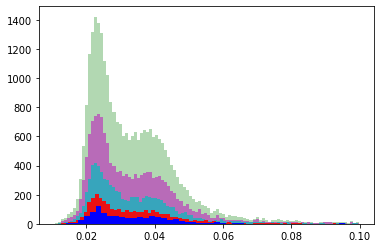

In [23]:
plt.hist(Y_error_train_val_7 , bins = 100 , alpha=0.3,color="g")
plt.hist(Y_error_train_val_6 , bins = 100 , alpha=0.5,color="m")
plt.hist(Y_error_train_val_5 , bins = 100 , alpha=0.7,color="c")
plt.hist(Y_error_train_val_4 , bins = 80 , alpha=0.9, color="r")
plt.hist(Y_error_train_val_3 , bins = 50 , alpha=1, color="b")
#plt.xlim(-5,30)
plt.show()

In [59]:
def razon_errores(valores , limite):
    menores = []
    mayores = []
    for i in range(len(valores)):
        if valores[i] <= limite:
            menores.append(i)
        else:
            mayores.append(i)
    print(len(menores) / (len(mayores) ))

razon_train_val_3 = razon_errores(Y_error_train_val_3 , 0.03)
razon_train_val_4 = razon_errores(Y_error_train_val_4 , 0.03)
razon_train_val_5 = razon_errores(Y_error_train_val_5 , 0.03)
razon_train_val_6 = razon_errores(Y_error_train_val_6 , 0.03)
razon_train_val_7 = razon_errores(Y_error_train_val_7 , 0.03)

0.9342359767891683
0.9556714471968709
0.9960079840319361
0.9595035924232528
0.971341203242782


In [60]:
print(" promedio error train_val_3: " ,  np.mean(Y_error_train_val_3)*100, "\n",
     "promedio error train_val_4: " ,  np.mean(Y_error_train_val_4)*100, "\n",
     "promedio error train_val_5: " ,  np.mean(Y_error_train_val_5)*100, "\n",
     "promedio error train_val_6: " ,  np.mean(Y_error_train_val_6)*100, "\n",
     "promedio error train_val_7: " ,  np.mean(Y_error_train_val_7)*100)
print("--------------------------------------------------------------------")
print(" mediana error train_val_3: " ,  np.median(Y_error_train_val_3)*100, "\n",
     "mediana error train_val_4: " ,  np.median(Y_error_train_val_4)*100, "\n",
     "mediana error train_val_5: " ,  np.median(Y_error_train_val_5)*100, "\n",
     "mediana error train_val_6: " ,  np.median(Y_error_train_val_6)*100, "\n",
     "mediana error train_val_7: " ,  np.median(Y_error_train_val_7)*100)

 promedio error train_val_3:  3.331753688968634 
 promedio error train_val_4:  3.3450137762863723 
 promedio error train_val_5:  3.339581431179543 
 promedio error train_val_6:  3.348711253811788 
 promedio error train_val_7:  3.344231888818594
--------------------------------------------------------------------
 mediana error train_val_3:  3.0701351243777815 
 mediana error train_val_4:  3.0344057605714823 
 mediana error train_val_5:  3.002729816852311 
 mediana error train_val_6:  3.039096053210532 
 mediana error train_val_7:  3.0272296183079717


In [62]:
def MAD_pred(Y,Y_hat):  
    R_percent = (Y - Y_hat) / Y *100
    s_mad = 1.4826 * np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

def MAD_residual(R_percent):  
    s_mad = 1.4826 * np.median(np.abs(R_percent - np.median(R_percent)))
    return s_mad

In [63]:
mad_error_train_val_3 = MAD_residual(Y_error_train_val_3*100)
mad_error_train_val_4 = MAD_residual(Y_error_train_val_4*100)
mad_error_train_val_5 = MAD_residual(Y_error_train_val_5*100)
mad_error_train_val_6 = MAD_residual(Y_error_train_val_6*100)
mad_error_train_val_7 = MAD_residual(Y_error_train_val_7*100)

print("mad error train_val_3: ", mad_error_train_val_3,"\n",
     "mad error train_val_4: ", mad_error_train_val_4,"\n",
     "mad error train_val_5: ", mad_error_train_val_5,"\n",
     "mad error train_val_6: ", mad_error_train_val_6,"\n",
     "mad error train_val_7: ", mad_error_train_val_7)

mad error train_val_3:  1.152596100863585 
 mad error train_val_4:  1.1096577875449283 
 mad error train_val_5:  1.108000843576499 
 mad error train_val_6:  1.140506975434073 
 mad error train_val_7:  1.1288166654050544


In [ ]:
pred = Global_model.predict([X_test, K_mag_test , X_offset_test, Y_error_test])